In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from tqdm import tqdm
from statsmodels.tsa.seasonal import STL

import sys 
sys.path.insert(1, "../")
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import ast

import dask.dataframe as dd
from dask.dataframe import from_pandas
import json

from collections import defaultdict
from workloads.util import use_results, use_dataset, join_queries_features

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'sktime'

In [4]:
dataset_dir = use_dataset("azure")

/data/wooders/ralf-vldb//datasets/azure


In [5]:
#df = pd.read_csv("/data/wooders/azure/vm_cpu_readings-file-1-of-195.csv")

In [33]:
dfs = []
test = True
if test: 
    test_keys = json.load(open("test_keys.json", "r"))
for file in tqdm(os.listdir(dataset_dir)):
    if not file.endswith(".csv") or "schema" in file: continue 

    df = pd.read_csv(os.path.join(dataset_dir, file), header=None)
    df.columns=["timestamp", "vm_id", "min", "max", "avg"]
    if test: 
        df = df[df.vm_id.isin(test_keys)]

    dfs.append(df)
    #if len(dfs) >= 3: break
  

100%|██████████| 9/9 [05:05<00:00, 33.92s/it]


In [34]:
dfs[0]

,timestamp,vm_id,min,max,avg
45544,80100,kyCjJRF6wJtFpFcf1e5qpaCvMhGzwYIyqTMnPgPWuJZbCV...,0.181789,3.927840,1.700451
45545,80100,OxnvTtD8HVE86ZRuMlM3b76MBbUL+Rt4QSqqyCeSB+po8a...,0.640966,1.394346,0.919743
45546,80100,D3sqz0npFD3v6VqJG0k33zEvOiscFSSb12GYazz634mKs8...,2.369279,79.577758,7.843582
45548,80100,u11JZYQETO83diVD5ffoqQc+RvgCTJx5d1nXG7QxHuKBoy...,7.525755,10.592764,8.451798
45550,80100,wYMq8ESCXiu3CYAwgcEVzW48JS+oRixaExyc+T4CbWRRgg...,1.338155,9.838779,5.431936
...,...,...,...,...,...
9990448,93600,WPgv3rmeAjCaIn+NNGOvofvvL6NyhgBh+BEkAGQJ0HTwAH...,1.659131,13.024813,3.150655
9990449,93600,hFSlIMvwonA9ZbXgupTa02OUc0EWp5jR5Ni+yh9FDbyCP+...,11.907817,14.643764,12.587700
9990453,93600,8ntrdFN7gwosjT8eriK9bWGzVzCmYqiKNIF2vJKq3RE7cl...,4.119876,35.198791,10.262689
9990456,93600,45xXd0tdlsDmz2Ej6G2Luy3jx+IEWIUUmgDEmJdlPkHw38...,5.361053,38.388881,17.713672


In [35]:
df = pd.concat(dfs)
df

,timestamp,vm_id,min,max,avg
45544,80100,kyCjJRF6wJtFpFcf1e5qpaCvMhGzwYIyqTMnPgPWuJZbCV...,0.181789,3.927840,1.700451
45545,80100,OxnvTtD8HVE86ZRuMlM3b76MBbUL+Rt4QSqqyCeSB+po8a...,0.640966,1.394346,0.919743
45546,80100,D3sqz0npFD3v6VqJG0k33zEvOiscFSSb12GYazz634mKs8...,2.369279,79.577758,7.843582
45548,80100,u11JZYQETO83diVD5ffoqQc+RvgCTJx5d1nXG7QxHuKBoy...,7.525755,10.592764,8.451798
45550,80100,wYMq8ESCXiu3CYAwgcEVzW48JS+oRixaExyc+T4CbWRRgg...,1.338155,9.838779,5.431936
...,...,...,...,...,...
9824504,79800,zCt3XvrzDOgRNZJe/Q5ju02SAchwjqHDvvYIQobIZhRv+n...,4.981131,11.447565,7.444950
9824505,79800,M5OsKfMmMsrOz9h9DDr3x0y+PQL1jaU/Y/HgMFFV2FkoMv...,0.571329,4.274882,2.174440
9824507,79800,cjyC9rZBKCcVh9Mr45nWCYPvmRRaC59odu/XHjerW1suWo...,4.724025,50.161330,12.422472
9824508,79800,3oCJmoqkLZQ5XUO3iaIomOWc+2DRq/FgrPLbvMLWXYPAV7...,6.082553,61.954037,12.575630


In [36]:
df.columns=["timestamp", "vm_id", "min", "max", "avg"]

In [37]:
df.vm_id.value_counts()

INELxr/I5SJ/gnaB7rObrPp3QVQyMDRDfYTlqtou9YJFMVUF8F4ofIft5jjU77MM    356
CibcXn41u6hYjyj8AjPt+ZV8x12mkts9pelAuTUvommQJKrngZh+YqqNm3f4S9ZA    356
BTIedl6cblUldT8gadbYk1eaDKR99uDGoPWKaAJQVzKIM4Pu93D+4UkQnMLKZvZQ    356
TrBGRgHfE9BdZ71AKHC7m5kF+iT8niyXBYabV2za/do9+AXyOgYjbI+zgh7fDR33    356
FFl28uXYhH9d+LXYALYS4NGgrGmbenQvxy0aB5TNRyW1ShbRpoKgQQQi0Mat9S/5    356
                                                                   ... 
iXtVIm+BTErJuvUnmAy1K5Nffm+8Ef/zCCU4lIG0A4QMPhuYFH4jkNohl+Vuds9b    199
LUYZYEj7ntVIaPtLAMA4dDRcecT+TNGEIZDPN6v7e0i7ojkXnhwWqUP93WPHPa0F    179
kGOILkcLAx9f0BP1EwwF8I6Uxp2IyCsBF9x5rEEMOZxg29giJBZxsCoXqI6ccmpC    175
WYeqyL8kujAHQX6+AuPIhEBhIq6OIZpkTaMizLjCHRonYqgFUXcv5qS2VuHzJv7J    162
FRlef8jcAcXgCM4rsODluyvfe6TUISZTflHvkOqbpxjLZSzFLM+CaQVR4LsU7wwO    140
Name: vm_id, Length: 1000, dtype: int64

In [38]:
df.timestamp.value_counts().sort_index()

0         976
300       976
600       976
900       978
1200      979
         ... 
105300    979
105600    979
105900    978
106200    976
106500    975
Name: timestamp, Length: 356, dtype: int64

In [39]:
df[df["timestamp"] == 0].vm_id.value_counts()

Nd3EbchpIpH78lkXQtoLORmfnl9qIxRNJKeL5AnwaBPvqTsOb4aZC1wITGIMcfO7    1
1qd5Z5M1+Ipq5jyC3TpIVgyvk0drxKwJtEGnCe0ix1yphdSrP5obgNGKVEvghzPg    1
VnIbDmsPp7ajAP9BtE8drozM1FbuYoIZLY8g9po4h2GZyVNfwiWQoviA2076nXzA    1
s92z3yrn7eV8hGsfwfQdXqgJ+8mlAz+5l78FA96yWtAyJByx0U2eNVNCNZ9iwEL1    1
/9h/fgxPgsU3RxBCLYjVwTFU4syldmFGirWQNH2aIcgjjf5GkxIQS0SUclKkpCNr    1
                                                                   ..
PHbcanatAoOCA8NbQxndlTV3Eg/1TmcvuQ/fKk/KxVy5s9SHQZJpjreBHpubYF8w    1
y/nbgJ3zCZ+shA/NP53/sdZHq+A7FEwLa6yvUPLA1RwKjtsUxCKBsM14+6tIx6Sq    1
B+T+N5gZxKPC2rqBlM6dQSvmkoxvLZtLUzoL1PVQCKz4aOPq0tbYp60YUr57a1cN    1
yu3PK8knBITespniVKwiFCn4xUlY2IVVgTE4t+Ugx+Bz6gooba45SB+jv+Fscdyy    1
3XWgHWbuNXNeSddYmdSpFOfdIwGkyCH9vTH4DCNjG4FzisvkOGxDRy4PTCzHiHpX    1
Name: vm_id, Length: 976, dtype: int64

In [22]:
key_counts = df.vm_id.value_counts()
key_counts = key_counts[key_counts >= key_counts.max()]
key_counts

kzEzcYi3pvCGAQtMZp2Rh21D6hQEWxoLJlOiqorT0GNyYp3jVowjL5t6ABVhq3wB    92
ALXjm1bqlfw4+u5M1zxitNDy2tcXrZfbglA1qCy87N6Tbj7X8CTQYkoDmwJ3WL+f    92
rM3aelLck5c5CvyOWn6vYLP/hf1OsLYqrlsxJXnpGwyj4KfCGMUySyp++JbReGBz    92
O0GeLVWDxPdqFetiKZ/Uyl7LVg+7YjvU9LwovRl1hwqcocwtxHS5UX12hy7fhaM+    92
hVXkoWeVzxHgXAPzhtDttaWwDP0u66TMdzE/02lRISsrIFr9Os0KH7j/wl5yC0NK    92
                                                                    ..
FsZo6hlAtQqxMzcvvPY9Ib+MFfENfiyA89rMX77sVv6iBEulGAs+iMIUJ78Na4pG    92
R6Nav82htU1KBgTF8t60TuR1BduQAcwlx1CTRabsSn8xthyIYU2B8if0gMBTWIR/    92
Tfyu9HNto75VYujiYRlkAAnZPvHaFdhzFWXP0Jc9Y0ZaXSz+R6LMwXdQhm0vCiTR    92
7Ppa4573VMpbKu7N9uHgF7xzdLAnGSwH2jd5RcExSrGhb2pE4lt5GtsXkEjnn8EB    92
ui1tK7P9fJxOiCNXJ1W9j39ZuG/hQOyqeCX2dH6PtA0VGxytDo3VhQDpon6JpYbX    92
Name: vm_id, Length: 1332, dtype: int64

In [23]:
test_ids = key_counts.sample(1000)
test_ids = test_ids.index.tolist()

In [25]:
json.dump(test_ids, open("test_keys.json", "w"))

In [41]:
test_df = df[df["vm_id"].isin(test_ids)]

In [42]:
test_df

,timestamp,vm_id,min,max,avg
45544,80100,kyCjJRF6wJtFpFcf1e5qpaCvMhGzwYIyqTMnPgPWuJZbCV...,0.181789,3.927840,1.700451
45545,80100,OxnvTtD8HVE86ZRuMlM3b76MBbUL+Rt4QSqqyCeSB+po8a...,0.640966,1.394346,0.919743
45546,80100,D3sqz0npFD3v6VqJG0k33zEvOiscFSSb12GYazz634mKs8...,2.369279,79.577758,7.843582
45548,80100,u11JZYQETO83diVD5ffoqQc+RvgCTJx5d1nXG7QxHuKBoy...,7.525755,10.592764,8.451798
45550,80100,wYMq8ESCXiu3CYAwgcEVzW48JS+oRixaExyc+T4CbWRRgg...,1.338155,9.838779,5.431936
...,...,...,...,...,...
9824504,79800,zCt3XvrzDOgRNZJe/Q5ju02SAchwjqHDvvYIQobIZhRv+n...,4.981131,11.447565,7.444950
9824505,79800,M5OsKfMmMsrOz9h9DDr3x0y+PQL1jaU/Y/HgMFFV2FkoMv...,0.571329,4.274882,2.174440
9824507,79800,cjyC9rZBKCcVh9Mr45nWCYPvmRRaC59odu/XHjerW1suWo...,4.724025,50.161330,12.422472
9824508,79800,3oCJmoqkLZQ5XUO3iaIomOWc+2DRq/FgrPLbvMLWXYPAV7...,6.082553,61.954037,12.575630


<AxesSubplot:xlabel='timestamp'>

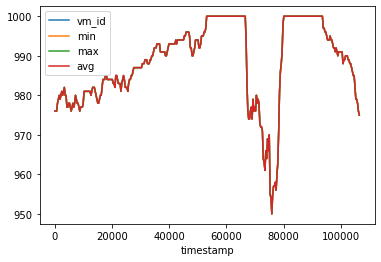

In [43]:
test_df.groupby(by="timestamp").count().plot()

<AxesSubplot:xlabel='timestamp,vm_id'>

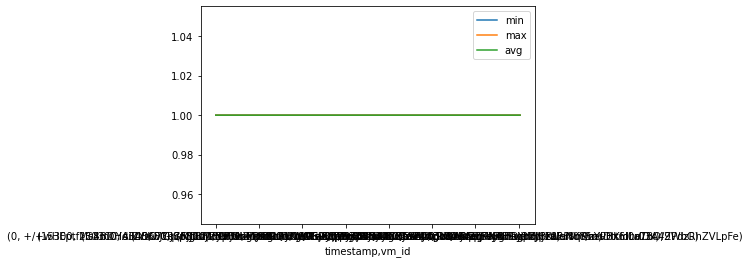

In [44]:
test_df.groupby(by=["timestamp", "vm_id"]).count().plot()

In [45]:
test_df.groupby(by="vm_id").count().sort_values(by="avg")

,timestamp,min,max,avg
vm_id,,,,
FRlef8jcAcXgCM4rsODluyvfe6TUISZTflHvkOqbpxjLZSzFLM+CaQVR4LsU7wwO,140,140,140,140
WYeqyL8kujAHQX6+AuPIhEBhIq6OIZpkTaMizLjCHRonYqgFUXcv5qS2VuHzJv7J,162,162,162,162
kGOILkcLAx9f0BP1EwwF8I6Uxp2IyCsBF9x5rEEMOZxg29giJBZxsCoXqI6ccmpC,175,175,175,175
LUYZYEj7ntVIaPtLAMA4dDRcecT+TNGEIZDPN6v7e0i7ojkXnhwWqUP93WPHPa0F,179,179,179,179
iXtVIm+BTErJuvUnmAy1K5Nffm+8Ef/zCCU4lIG0A4QMPhuYFH4jkNohl+Vuds9b,199,199,199,199
...,...,...,...,...
LvidroAXRoHdADxX53woHKMgnVc9O2pkNFNlJ8Ooo5o9RBUkUIa1JiRaWpVYJpD2,356,356,356,356
M1JAyNceZDOvr5Mk1xPHSolBiqjIsGkKHDEEQYkMt4MJEmOCAP02Glft7Y0QLlly,356,356,356,356
M5OsKfMmMsrOz9h9DDr3x0y+PQL1jaU/Y/HgMFFV2FkoMv8lE5ZgdHbzGSs+jn/c,356,356,356,356


In [51]:
test_df.groupby(by="vm_id").timestamp.min().value_counts()

0        976
900        2
53100      2
52800      1
3000       1
20400      1
45900      1
9000       1
31500      1
34500      1
12900      1
15900      1
2100       1
33300      1
1500       1
42300      1
30000      1
45300      1
1200       1
23700      1
33900      1
51300      1
27600      1
Name: timestamp, dtype: int64

In [ ]:
test_df[test_df["vm_id"] == "iM3xUsfYSOvqWKx9xxfAxs8dvc64EgZ6iXHc+vaHB0QwClBYOknOYFqQvuXt89i9"]

In [ ]:
test_df[test_df["vm_id"] ==j "Q7rurwAAouuL6HsYHCRauV1v8pWu3Hto/0AdVtdR2KmfOkSbLTTT7++1ECIKmzcv"]

In [55]:
test_df = test_df.sort_values(by="timestamp")

In [57]:
data = {}
key_df = test_df.groupby(by="vm_id")
for key in test_ids:
    group = key_df.get_group(key)
    timestamps = group.timestamp.tolist()
    values = group.avg.to_numpy()

    if timestamps[0] != 0: 
        print("non-zero start")
        #print(timestamps)
        continue 
    if len(values) < 45: 
        print("too few values")
        continue

    data[key] = values

print(len(data.keys()))

non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
non-zero start
976


In [66]:
cache = {}

In [70]:
def get_model(key, ts):

    if key in cache and ts in cache[key]:
        return cache[key][ts]

    if key not in cache: 
        cache[key] = {}

    chunk = data[key][ts - WINDOW_SIZE : ts]
    last_model = STLForecast(
        chunk, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=24
    ).fit()
    #print("new model", key, ts, last_model.model_result.mse, last_model)
    cache[key][ts] = {"model": last_model, "forecast": last_model.forecast(1000), "data": chunk, "time": ts}
    return cache[key][ts]

In [84]:
WINDOW_SIZE = 48
MAX_LEN = 300

def max_score(score):
    max_score = 0
    max_key = None
    for key in score.keys():
        if score[key] >= max_score: 
            max_score = score[key]
            max_key = key

    return max_key

def experiment(test_start, runtime, policy):

    predictions = defaultdict(list)
    values = defaultdict(list)
    staleness = defaultdict(list)
    score = {key: 0 for key in data.keys()}
    update_times = defaultdict(list)
    
    last_model = {key: get_model(key, test_start) for key in data.keys()} 
    next_update_time = test_start + runtime # time when model is completed

    for ts in tqdm(range(test_start, MAX_LEN, 1)):
        #print(total_error)

        # run predictions per key 
        for key in last_model.keys(): 
            #print("key", key, last_model[key]["forecast"])
            last_time = last_model[key]["time"]
            predictions[key].append(last_model[key]["forecast"][ts-last_time])
            values[key].append(float(data[key][ts]))
            staleness[key].append(ts-last_time)

            # policy scoring
            t = ts - last_time
            if policy == "total_error" and len(predictions[key]) > 1 and t > 1: 
                e = mean_absolute_scaled_error(
                    np.array(values[key][-t:]), 
                    np.array(predictions[key][-t:]), 
                    y_train=np.array(values[key][-t:]), 
                    sp=1
                )
                score[key] = e * t # use total, not mean 
            elif policy == "round_robin": 
                score[key] += 1
            elif policy == "max_staleness": 
                score[key] = ts-last_time

        # can update model
        while ts >= next_update_time: 
            # pick max error key 
            #key = np.array(score).argmax() + 1
            key = max_score(score)
            #print(key, score)
            
            # mark as update time for key  
            update_times[key].append(ts) 
            last_model[key] = get_model(key, ts)
            score[key] = 0
            
            # update next update time 
            next_update_time += runtime

    results_df = pd.concat([
        pd.DataFrame({
            "y_pred": predictions[key], 
            "y_true": values[key], 
            "staleness": staleness[key], 
            "key": [key] * len(predictions[key])
        })
        for key in predictions.keys()
    ])
    return update_times, results_df

In [ ]:
test_start = WINDOW_SIZE

update_times, results_df = experiment(test_start, 0.5, "round_robin")
update_times

In [73]:
def error(df):
    total = 0
    for key in df.groupby("key").groups.keys(): 
        e = mean_absolute_scaled_error(
            df[df["key"] == key].y_pred, 
            df[df["key"] == key].y_true, 
            y_train=df[df["key"] == key].y_true
        )
        total += e
    return total 

In [74]:
from workloads.util import use_results
import os 

result_dir = use_results("azure")
result_dir

'/data/wooders/ralf-vldb//results/azure'

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
recompute = True

In [77]:
runtime = [1, 2, 4]
policy = ["round_robin", "total_error"]

results_df = pd.DataFrame()
updates_df = pd.DataFrame()
df_all = pd.DataFrame()

for r in runtime: 
    for p in policy: 
        
        name = f"{p}_{r}_A1"
        print(name)
        # skip completed
        if not recompute and os.path.exists(f"{result_dir}/{name}/simulation_predictions.csv"):
            df = pd.read_csv(f"{result_dir}/{name}/simulation_predictions.csv")
            r_df = pd.read_csv(f"{result_dir}/{name}/simulation_result.csv")
            u_df = pd.read_csv(f"{result_dir}/{name}/simulation_update_time.csv")
        else: 
            update_times, df = experiment(test_start=WINDOW_SIZE, runtime=r, policy=p)
            e = error(df)
            s = df.staleness.mean()
            u = sum([len(v) for v in update_times.values()])

            r_df = pd.DataFrame([[r, p, e, s, u]])
            r_df.columns = ["runtime", "policy", "total_error", "average_staleness", "total_updates"]
            u_df = pd.DataFrame([
                [r, p, k, i, update_times[k][i]]
                for k, v in update_times.items() for i in range(len(v))
            ])
            u_df.columns = ["runtime", "policy", "key", "i", "time"]

            os.makedirs(f"{result_dir}/{name}", exist_ok=True)
            df.to_csv(f"{result_dir}/{name}/simulation_predictions.csv")
            r_df.to_csv(f"{result_dir}/{name}/simulation_result.csv")
            u_df.to_csv(f"{result_dir}/{name}/simulation_update_time.csv")
        
        df_all = pd.concat([df_all, df])
        results_df = pd.concat([results_df, r_df])
        updates_df = pd.concat([updates_df, u_df])
        
results_df.to_csv(f"{result_dir}/simulation_results.csv")

  0%|          | 0/252 [00:00<?, ?it/s]

round_robin_1_A1


  0%|          | 0/252 [00:00<?, ?it/s]

total_error_1_A1


  0%|          | 0/252 [00:00<?, ?it/s]

round_robin_2_A1


  0%|          | 0/252 [00:00<?, ?it/s]

total_error_2_A1


  0%|          | 0/252 [00:00<?, ?it/s]

round_robin_4_A1


  0%|          | 0/252 [00:00<?, ?it/s]

total_error_4_A1


100%|██████████| 252/252 [01:45<00:00,  2.40it/s]


In [78]:
result_df = pd.read_csv(f"{result_dir}/simulation_results.csv")

In [79]:
import seaborn as sns
sns.set_theme(style="whitegrid")

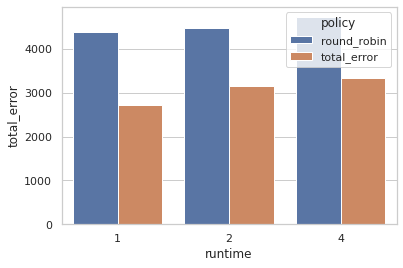

In [80]:
ax = sns.barplot(x="runtime", y="total_error", hue="policy", data=result_df)

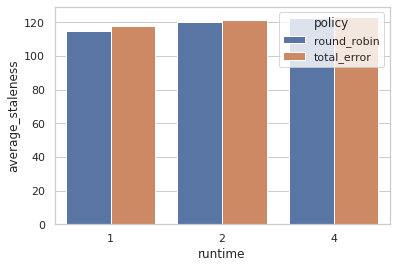

In [81]:
ax = sns.barplot(x="runtime", y="average_staleness", hue="policy", data=result_df)

In [82]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

d = updates_df.groupby(["key", "runtime", "policy"]).size().unstack("key", fill_value=0)
d

key                  +/+wHEptfMc4BDHAIVviKFJGJSp8tUMfdp0xxMyhgUIfBVWG/eQqbgNStNUGHusE  \
runtime policy                                                                          
1       round_robin                                                  1                  
        total_error                                                  0                  
2       round_robin                                                  1                  
        total_error                                                  0                  
4       round_robin                                                  1                  
        total_error                                                  0                  

key                  +/xSb3UfIhJmIM0B03TBsa1t8mT621pu2jIUJ3viMmg5teOK8WywQnqZlht1TaOr  \
runtime policy                                                                          
1       round_robin                                                  1                  
        total_error                                                  0                  
2       round_robin                                                  0                  
        total_error                                                  0                  
4       round_robin                                                  0                  
        total_error                                                  0                  

key                  +2NL56xf9VZLUNZs4/MtQC379HR1Wn/C0gT1N1SzgKlWvfmgPnMbTQ9FsqJz1Bms  \
runtime policy                                                                          
1       round_robin                                                  1                  
        total_error                                                  0                  
2       round_robin                                                  1                  
        total_error                                                  0                  
4       round_robin                                                  1                  
        total_error                                                  0                  

key                  +mVkhY5xU687sTWbLgFNJQGq+/UC/hE/VitJtOuJkglhWOSf8BE2Oetpriic6Jbm  \
runtime policy                                                                          
1       round_robin                                                  1                  
        total_error                                                  0                  
2       round_robin                                                  0                  
        total_error                                                  0                  
4       round_robin                                                  0                  
        total_error                                                  0                  

key                  //IUkVFEStODP4hq09Sc0uj9VowvK8dl2zoYtsfSH4Zaglwwfo1m6CYUXpHT2WDF  \
runtime policy                                                                          
1       round_robin                                                  0                  
        total_error                                                  1                  
2       round_robin                                                  0                  
        total_error                                                  0                  
4       round_robin                                                  0                  
        total_error                                                  0                  

key                  //OKfzeE0qxA+Rv4phu+pT3K6aq/Xrog2jPe6Rtq+Dl/j7DPlbXiiDKicMt4iOe2  \
runtime policy                                                                          
1       round_robin                                                  0                  
        total_error                                                  1                  
2       round_robin                                                  0         

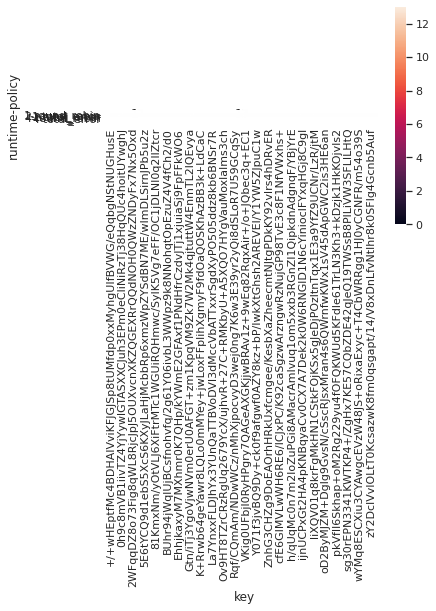

In [83]:
ax = sns.heatmap(d, square=True, annot=True)